In [ ]:
# =============================================================================
# Example 02: Laplacian Test for a Homogeneous Tetrahedron
# -----------------------------------------------------------------------------
# Description:
#     This example performs a Laplacian test on the gravitational potential
#     computed for a homogeneous tetrahedron, verifying the validity of
#     Poisson’s and Laplace’s equations across the interior and exterior domains.
#
#     The Laplacian ∇²V is evaluated numerically on a 2D grid in the plane
#     z = 1/2 intersecting a unit tetrahedron defined by vertices:
#         A(0,0,0), B(0,1,0), C(1,0,0), D(0,0,1)
#
#     Blue regions correspond to interior points (∇²V ≈ −4π),
#     red regions correspond to exterior points (∇²V ≈ 0),
#     and white delineates the tetrahedral boundary.
#
#     The color-coded Laplacian field reproduces Figure 4(b) in the paper.
#
# Reference:
#     Periyandy, T., & Bevis, M. (2025).
#     "The Gravitational Potential Inside, On and Outside of a Homogeneous Tetrahedron." 
#
#     Supplementary Material: Laplacian Test (Python Implementation)
#
# Authors:
#     Thunendran Periyandy  (corresponding author)
#     Michael Bevis
#
# Date: November 2025
# =============================================================================


In [2]:
import sys
sys.path.append("./python")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.spatial import ConvexHull

from Laplace_main import TetrahedronLaplaceTest

In [3]:
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 16,
    "font.size": 16,
    "legend.fontsize": 16,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
})

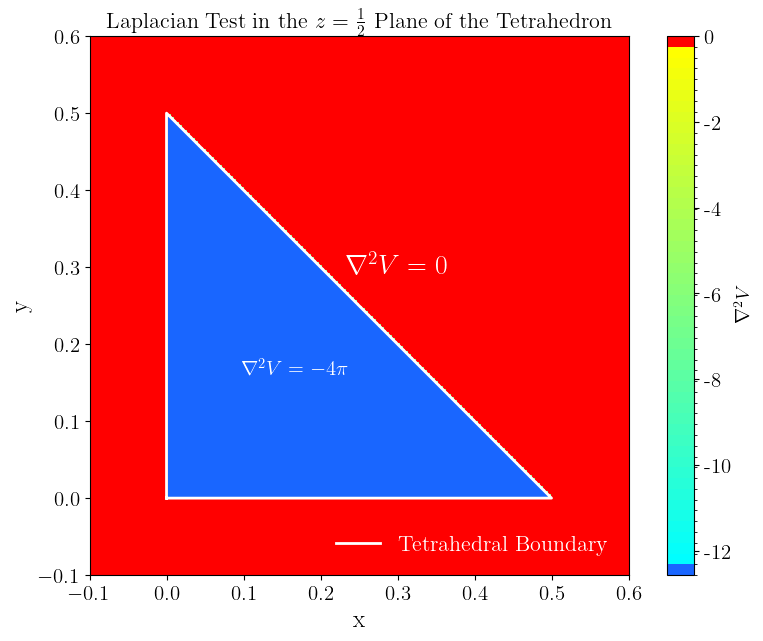

In [4]:
# --- Define standard unit tetrahedron ---
vertices = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0]
])
vA, vB, vC, vD = vertices

# --- Create Laplace tester (no need for manual phi/laplacian) ---
laplace_tester = TetrahedronLaplaceTest(vA, vB, vC, vD)

# --- Compute Laplacian grid ---
z_fixed = 0.5
x_range = (-0.1, 0.6)
y_range = (-0.1, 0.6)
X, Y, laplacian_grid = laplace_tester.compute_laplacian_grid(z_fixed, x_range, y_range, resolution=200)

# --- Edge-plane intersection ---
def edge_intersection(v1, v2, z_plane):
    z1, z2 = v1[2], v2[2]
    if (z1 - z_plane) * (z2 - z_plane) < 0:
        t = (z_plane - z1) / (z2 - z1)
        return v1 + t * (v2 - v1)
    return None

edges = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]
z_plane = z_fixed
intersection_points = []
for i, j in edges:
    pt = edge_intersection(vertices[i], vertices[j], z_plane)
    if pt is not None:
        intersection_points.append(pt)
intersection_points = np.array(intersection_points)

# --- Custom colormap ---
N = 50
colors = [(0.1, 0.4, 1)]  # Start with blue
for i in range(1, N-1):
    ratio = (i-1)/(N-3)
    colors.append((ratio, 1.0, 1.0 - ratio))  # Cyan → Yellow
colors.append((1, 0, 0))  # Red
cmap_discrete = ListedColormap(colors)

vmin = -4 * np.pi
vmax = 0
bounds = np.linspace(vmin, vmax, N+1)
norm = BoundaryNorm(bounds, cmap_discrete.N)

# --- Plotting ---
fig, ax = plt.subplots(figsize=(10, 7))
im = ax.imshow(laplacian_grid, extent=(x_range[0], x_range[1], y_range[0], y_range[1]),
               origin='lower', cmap=cmap_discrete, norm=norm, interpolation='nearest')

cbar = plt.colorbar(im, ax=ax, boundaries=bounds)
cbar.set_ticks([-12, -10, -8, -6, -4, -2, 0])
cbar.set_ticklabels([str(t) for t in [-12, -10, -8, -6, -4, -2, 0]])
cbar.set_label(r'$\nabla^2 V$', fontsize=14)

# --- Plot tetrahedral boundary ---
if len(intersection_points) >= 3:
    hull = ConvexHull(intersection_points[:, :2])
    boundary = intersection_points[hull.vertices]
    ax.plot(np.append(boundary[:, 0], boundary[0, 0]),
            np.append(boundary[:, 1], boundary[0, 1]),
            color='white', linewidth=2, label='Tetrahedral Boundary')

# --- Labels ---
ax.set_title(r"Laplacian Test in the $z = \frac{1}{2}$ Plane of the Tetrahedron", fontsize=16)
ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('y', fontsize=18)
ax.grid(False)
legend = ax.legend(loc='lower right', frameon=False)
for text in legend.get_texts():
    text.set_color('white')

interior_x = np.mean(intersection_points[:, 0])
interior_y = np.mean(intersection_points[:, 1])
ax.text(interior_x, interior_y, r'$\nabla^2 V = -4\pi$', color='white',
        fontsize=15, ha='center', va='center', fontweight='bold')

outside_x = x_range[1] - 0.3
outside_y = y_range[1] - 0.3
ax.text(outside_x, outside_y, r'$\nabla^2 V = 0$', color='white',
        fontsize=20, ha='center', va='center', fontweight='bold')

# --- Save and show ---
plt.savefig("laplacian_unit_tetrahedron_slice.png", dpi=300, bbox_inches='tight')
plt.show()
